# Cas A as a gain calibrator

### Hans Moritz Günther (CXC/MIT) with Nick Durham and Akos Bogdan
### last updated: 2020-01-22

In [1]:
from IPython.display import HTML, Image

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy import table

import ciao_contrib.runtool as rt

%matplotlib inline

In [3]:
tab = table.Table.read('data/23261/repro/evt1_notgain_filts.fits', hdu='EVENTS')
tabi3 = tab[tab['ccd_id'] == 3]

In [4]:
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('div.prompt').hide();
 } else {
 $('div.input').show();
 $('div.prompt').show();
}
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the display of raw code."></form>''')


## How does the data look?

First, let's look at just one of the Cas A observations to get a feel for what to expect. I'm picking out just a single ObsID (23261) and make a simple, linearly scaled image, just to get a feel for how much of the detector is covered.

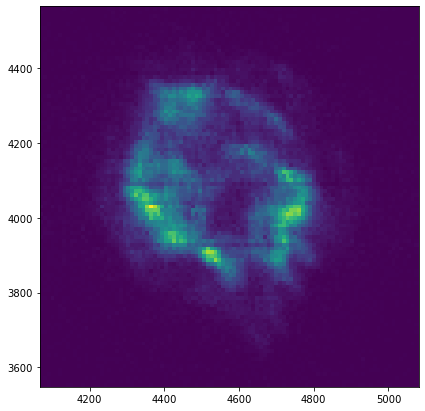

In [5]:
# Let's just check that the image is loaded correctly and the data look similar to what we expect
fig, ax = plt.subplots(subplot_kw={'aspect':'equal'}, figsize=(7, 7))
out = ax.hist2d(tabi3['detx'], tabi3['dety'], bins=100)

Counts image in DETX/Y (sky) coordinate system from ObsID 23261 on the I3 chip.

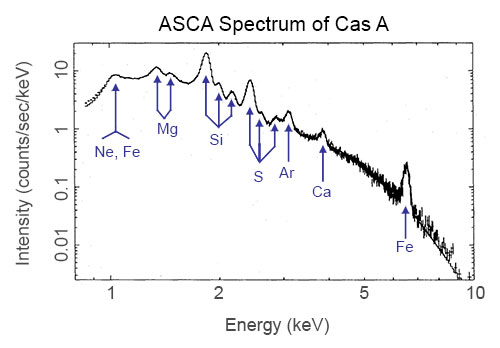

In [6]:
Image('figures/spectrum_casa_ASCA.jpg')

X-ray spectrum of supernova remnant Cas A from ASCA data. [Holt et al., PASJ 1994](https://ui.adsabs.harvard.edu/abs/1994PASJ...46L.151H/abstract)

The spectral resolution in ACIS is just a little less than in the ASCA data here, so looking at this CCD-resolution picture gives us an indication where we can fit just a single line and where we have to take line blends into account. The Fe and Ca lines are relatively isolated. Ar is close to a weaker S line, but the line ratio might of course change with position. The brightest S line has Si to the left and a fainter S line to the right. Si also has a blend to the right (with Si).

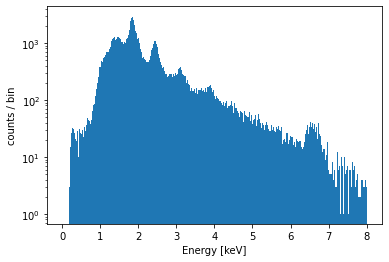

In [7]:
fig, ax = plt.subplots()
out = ax.hist(tabi3['energy'] / 1000, bins=1000, range=[0, 8])
ax.set_yscale('log')
ax.set_xlabel('Energy [keV]')
out = ax.set_ylabel('counts / bin')

This is a histrogram of all counts in the Chandra observation wiht ObsID 23261, reduced with CTI correction, but without GAIN correction (that's what we want to measure here after all). The same lines seen in the ACS spectrum are also visible here, but not resolved as well.

## Fitting one line at a time

As we see in the ASCA data, the spectrum is a little more complex that we'd like. Not too complex, but even the strong lines we'd like to look at are not truely isolated. I think it's the easiest to fit these lines with a very simple model, just a single Gauss for the line, plus a pseudo-continuum powerlaw. I'll fit the full data integrated over the entire chip to select the position and width of the Gaussian as well has the slope of the power-law. I fix the width of the Gaussian and use the position of the Gaussian and the slope of the powerlaw as starting values for the fits that I'll do on individual tiles. Having few parameters and starting the fit very close to the best-fit position speeds up the fitting process and reduces the risk that the fit runs into local minima (e.g. by fitting the Gaussian to a few photons that are just noise).

The fit is done using Sherpa's Cash statistic (which differes slightly from the formula in Cash's original paper), which is appropriate for unbinned Poisson data because it calculates the true Poisson likelihood. The algorithm to minimize this statistic is more of an implementation detail. I've found that the Nelder-Mead simplex minimizer works well.

In [8]:
from sherpa.stats import Cash
from sherpa.astro.data import DataPHA
from sherpa.optmethods import NelderMead
from fit_tile import (fit_allelem, plot_allelem,
                      fit_all, plot_loc_table, 
                      init_model,
                      extract_tile,
                      reg2im1024)

# Sherpa generates quite some output on screen,
# We'll silence some of that with these lines
import logging
sherpablog = logging.getLogger('sherpa')
sherpablog.setLevel(logging.WARNING)

# fit_start.txt is a table of initial values for the fit which are
# hand-selected to be close to the true value
fitstart = table.Table.read('fit_start.txt', format='ascii')

In [9]:
hist, edges = np.histogram(tabi3['pha'], bins=np.arange(-0.5, np.max(tabi3['pha'])))
d = DataPHA('reg', np.arange(np.max(tabi3['pha'])), hist)

fit_res, fit_err = fit_allelem(d, fitstart, init_model, errors=True, stat=Cash(), method=NelderMead())

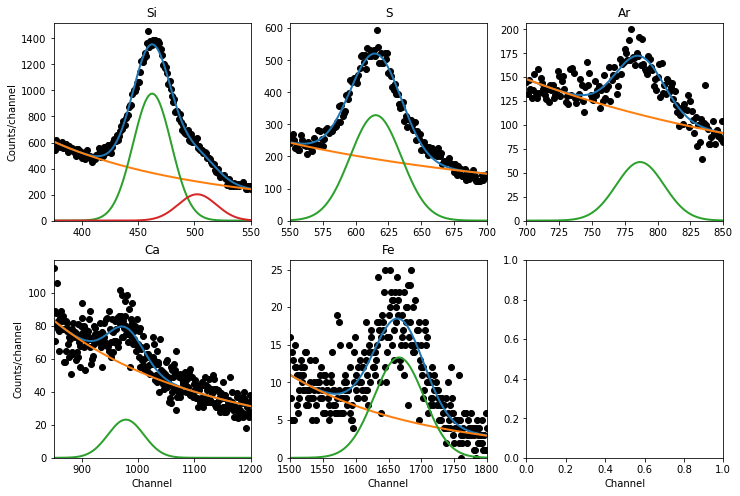

In [10]:
fig, axes = plot_allelem(d, fitstart, fit_res)

Fit to an entire ObsID, for five lines. This is useful to determine good starting values for fits of individual tiles.

This figure shows the fits using data from the entire I3 chip (for ObsID 23261). For Si I add in a second Gauss, because of the line blend, keeping the distance between the two fixed. The goal is not to get a perfect fit, but just something that's comparable between regions. So, if the width of a line is under- or overestimated, that's fine, as long as the position is OK. Even if the center position is slightly biased, that's OK, as long as it's biased in the same way for all regions.

I looked at these fits and tried out different initial parameters for the fits. As I said above, starting very close to the true position reduces the chances that the fit runs into the wrong direction when the signal is very low. These are the parameters I fould to work pretty well.

In [11]:
loc = table.Table.read('casa_pha_fits/23261/i3_noTG.lloc', format='ascii')

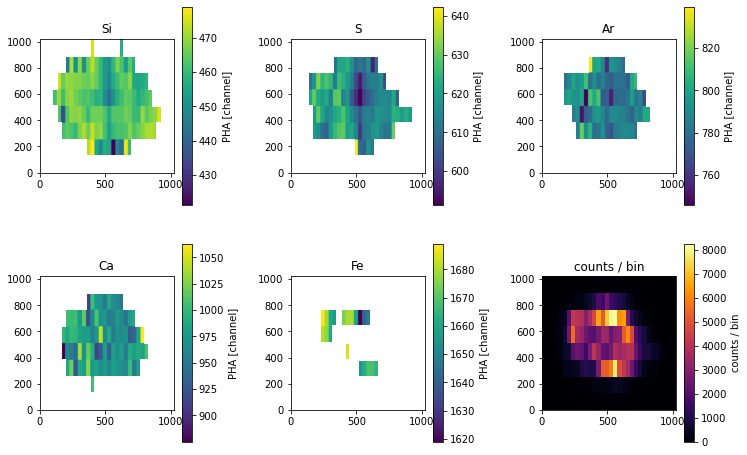

In [12]:
fig, axes = plot_loc_table(loc, tabi3, fitstart['element'])

This plot shows the fitted peak position of all lines for ObsID 23261. Regions with insufficient counts for a fit are left white in the image. The signal in Si is best, the Fe is lowest as expected and thus only very very regions reach the minimum number of counts that I require to perform a fit. I find regions with fewer than about 50 counts in the the fitted region are just too noisy to be useful, so I skip those.

In general, we can see the same spatial pattern that emerges from the ECS data, where some regions are clearly more noisy than others simply because there are fewer counts. Below, I show the data and fit from a tile with a low count number as example of how well the fit does. I have not inspected every single fit by hand, but the fact that all the examples perform well and the errors on the fitted values look sensible indicates to me that I can proceed and use those in fitting. In regions with low count numbers, the uncertainties will be much higher than in the regions with better signal, so those will contribute less when I match the PCA components to these images.

In [13]:
tile = extract_tile(tabi3, loc[61])
hist, edges = np.histogram(tile['pha'], bins=np.arange(-0.5, np.max(tile['pha'])))
dtile = DataPHA('reg', np.arange(np.max(tile['pha'])), hist)

fit_res, fit_err = fit_allelem(dtile, fitstart, init_model, errors=True, stat=Cash(), method=NelderMead())

### How does a fit for one tile look like?

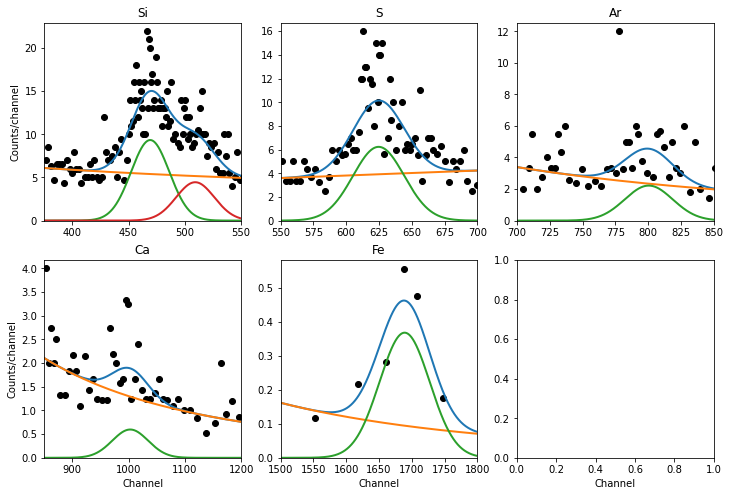

In [14]:
dtile.group_counts(10)
fig, axes = plot_allelem(dtile, fitstart, fit_res, fit_err=fit_err)

## Compare all 9 ObsIDs

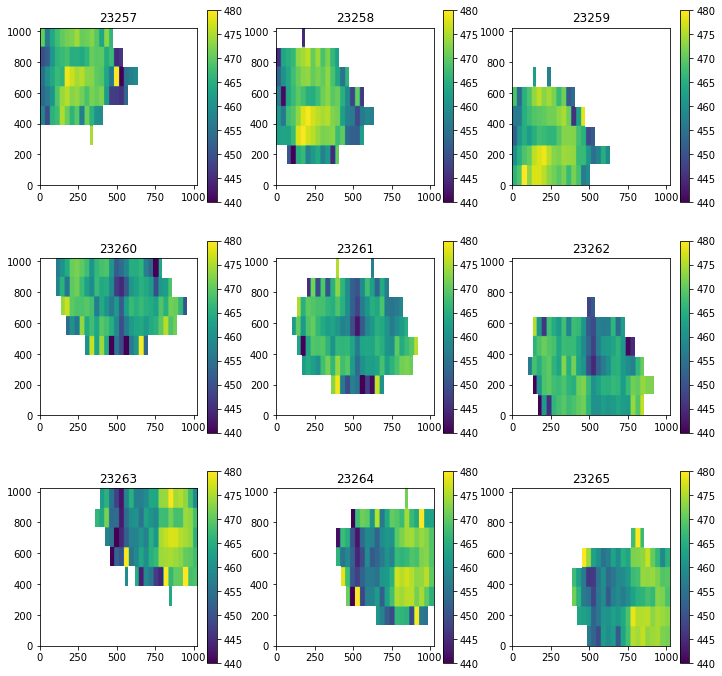

In [15]:
# Currently, selected sub-list of ObsIDs by hand
# put ObsID on plot

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), subplot_kw={'aspect':'equal'})
for i, obsid in enumerate([23257, 23258, 23259, 23260, 23261, 23262, 23263, 23264, 23265]):
    ax = axes.flatten()[i]
    loc = table.Table.read(f'casa_pha_fits/{obsid}/i3_noTG.lloc', format='ascii')
    im = ax.imshow(reg2im1024(loc, 'Si').T, origin='lower', vmin=440, vmax=480)
    ax.set_title(obsid)
    out = plt.colorbar(im, ax=ax)

PHA map from Si line for all 9 new ObsIDs. The same special structure can be seen for all of them. That's encouraging! Despite placing the source on different locations and doing independent fits, the fits look good (if noisy on the sides).

In [16]:
obsids = [23257, 23258, 23259, 23260, 23261, 23262, 23263, 23264, 23265]
evts = [table.Table.read(os.path.join('data', str(obsid),
                                    'repro/evt1_notgain_filts.fits'),
                         hdu='EVENTS')
            for obsid in obsids]
evtall3 = table.vstack(evts, metadata_conflicts='silent')
evtall3 = evtall3[evtall3['ccd_id'] == 3]


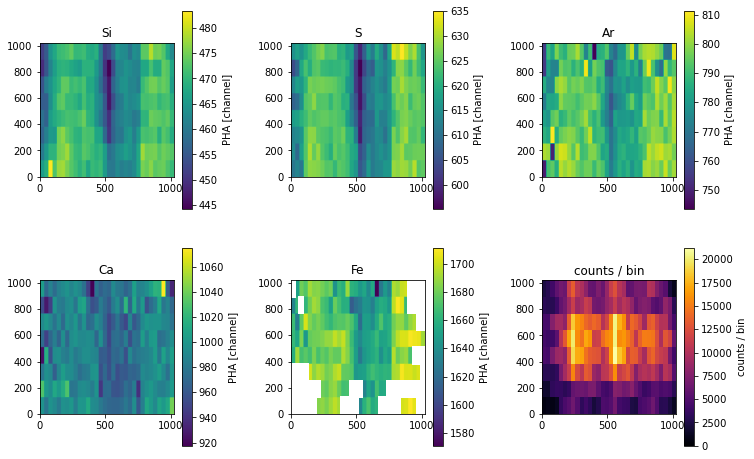

In [17]:
locall = table.Table.read(f'casa_pha_fits/23257o23258o23259o23260o23261o23262o23263o23264o23265/i3_noTG.lloc', format='ascii')
fig, axes = plot_loc_table(locall, evtall3, fitstart['element'])

All 9 ObsIDs combined fill the entire field (except for Fe, where the signal is lowest). The overall spatial structure is the same in all lines and it matches the ECS data.

## Fit PCA to incomplete data from one ObsID


In [18]:
obsid = 23261
n_comps = 4
# Need to index by ObsID
loc1 = table.Table.read(f'casa_pha_fits/{obsid}/i3_noTG.lloc', format='ascii')

In [19]:
from astropy.io import fits
hdus = fits.open('ACIS_PHA_PCA.fits')

pcacomps = hdus['i3_noTG'].data

In [20]:
from sherpa.models.basic import TableModel, Const1D
from sherpa.stats import Chi2
from sherpa.data import Data1D
from sherpa.fit import Fit

In [21]:
modelpca = []

for i in range(n_comps):
    comp = TableModel(name=f'comp{i}')
    comp.load(None, pcacomps[i, :, :].flatten())
    modelpca.append(comp)
top4 = sum(modelpca[1:], modelpca[0])

In [22]:
# make input data masked

# This is really just indexing over regions, but we need to pass in something for x...
x_array = np.arange(len(loc))

locdata = Data1D('locsi', x_array,                    
                 np.ma.masked_invalid(loc1['Si']),
                 staterror=loc1['Sierr'])

for m in modelpca:
    m.fold(locdata)

locfit = Fit(locdata, top4, stat=Chi2(), method=NelderMead())
locfit.fit()

Parameter,Best-fit value
comp0.ampl,-7458.93
comp1.ampl,37.7391
comp2.ampl,26.1234
comp3.ampl,-24.6758


In [23]:
fullccdpredicted = top4(x_array)
siall = locall['Si']
siall_err = locall['Sierr']

In [24]:
def plot_one_comp_nine(loc1, elem, fullccdpredicted, locall, obsid, vmin, vmax, vmaxerr=10):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 7), 
                             subplot_kw={'aspect':'equal', 'xticks':[], 'yticks':[]})

    im = axes[0,0].imshow(reg2im1024(loc1, elem).T, origin='lower', vmin=vmin, vmax=vmax)
    out = plt.colorbar(im, ax=axes[0, 0], extend='both')
    out.set_label('PHA [channel]')
    axes[0, 0].set_title(f'Observed from ObsID {obsid}')
    im = axes[0, 1].imshow(reg2im1024(loc1, elem + 'err').T, origin='lower', 
                           vmax=vmaxerr, vmin=0, cmap=plt.get_cmap('inferno'))
    out = plt.colorbar(im, ax=axes[0, 1], extend='max')
    axes[0, 1].set_title(f'Error on ObsID {obsid}')
    out.set_label('$\sigma_\mathrm{PHA}$ [channels]')

    im = axes[0, 2].imshow(fullccdpredicted.reshape((32, 8)).T, 
                      extent=[0, 1023, 0, 1023], origin='lower', vmin=vmin, vmax=vmax)
    out = plt.colorbar(im, ax=axes[0, 2], extend='both')
    out.set_label('PHA [channel]')
    axes[0, 2].set_title(f'Predicted from ObsID {obsid}')

    im = axes[1, 0].imshow(reg2im1024(locall, elem).T, origin='lower', vmin=vmin, vmax=vmax)
    axes[1, 0].set_title('Observed from 9 obs')
    out = plt.colorbar(im, ax=axes[1, 0], extend='both')
    out.set_label('PHA [channel]')

    im = axes[1, 1].imshow((fullccdpredicted / locall[elem]).reshape((32, 8)).T, 
                           extent=[0, 1023, 0, 1023], origin='lower',
                           cmap=plt.get_cmap('seismic'),
                           vmin=0.97, vmax=1.03)
    out = plt.colorbar(im, ax=axes[1, 1], extend='both')
    axes[1, 1].set_title('ratio predicted / obs')
    im = axes[1, 2].imshow(((fullccdpredicted - locall[elem]) / locall[elem + 'err']).reshape((32, 8)).T, 
                           extent=[0, 1023, 0, 1023], origin='lower',
                           cmap=plt.get_cmap('seismic'),
                           vmin=-5, vmax=5)
    plt.colorbar(im, ax=axes[1, 2], extend='both')
    axes[1, 2].set_title('ratio predicted / obs in $Chi2$')
    return fig, axes

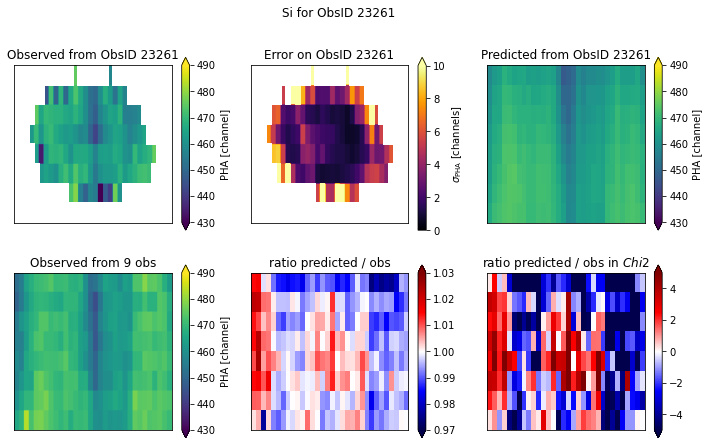

In [25]:
fig, axes = plot_one_comp_nine(loc1, 'Si', fullccdpredicted, locall, obsid, vmin=430, vmax=490)
out = fig.suptitle('Si for ObsID 23261')

*top row*: ObsID 23261. *left*: Peak position of Si line *middle*: Uncertainty on peak position *right*: predicted peak position from a fit of the top four PCA components.

*bottom row*: Comparison to best known value of the gain. Since we do not know the true value (putting the noise in the ECS data aside, it also does not cover this exact energy) of the gain at each point, we use the data from all nine ObsIDs combined. *left*: Fitted peak position of the Si line. *middle*: Ratio of predicted (from the PCA fitted to just one ObsID) and the best-known peak position of the Si line. *right*: Similar plot, but now devided by the statistical error on the best-known position in each tile.

This figure shows in some detail how we can fit the Cas A data with the top few PCA components. In order to evaluate the validity of the method, we need to compare the prediced the gain in each tile with the true gain for the Si line energy. Unfortunately, we do not have a doog measure of this quantity. The ECS data is noisy and also does not cover the exact energy. Thus, we merge the event lists from all nine observations and treat this much larger set that the baseline. Some caution is warrented: In Cas A kinematic motions are large enough disturb the measurement (plasma moves up to 1% of the speed of light, shifting the peak of the line position by up to 1%) and even in the coadded data, the S/N is no ideal close to the chip edges, simply because those edges are not illuminated very well given the coordinates chosen for the observations.

However, in general, we can see broad agreement between the maps of the peak positions predicted from just a single ObsID and the map measured from a combination of all nine ObsIDs. Systematic differences are seen on the left edge of the chip (red colums in the middle bottom panel) and in the top row (blue in the middle bottom panel). Both are regions that are not covered in ObsID 23261. We know from the PCA components however, that some components parameterize a dependence of the gain from the top to the bottom, presumably caused by CTI. Since ObsID 23261 covers mostly the middle of the chip, those components cannot be well constrainted in the fit. The plots above are for Si. 

Equivalent fits for S, Ar, and Ca are shown below.

In [26]:
loc =  table.Table.read('ecs_pha_fits/e1/i3_noTG.lloc', format='ascii',
                           header_start=1)
loc.keep_columns(['xlo', 'xhi', 'ylo', 'yhi'])

for elem in ['Si', 'S', 'Ar', 'Ca']:
    locdata = Data1D('locsi', x_array,                    
                 np.ma.masked_invalid(loc1[elem]),
                 staterror=loc1[elem + 'err'])

    for m in modelpca:
        m.fold(locdata)

    locfit = Fit(locdata, top4, stat=Chi2(), method=NelderMead())
    locfit.fit()
    fullccdpredicted = top4(x_array)
    loc[elem] = fullccdpredicted
    loc[elem].format='{:5.1f}'

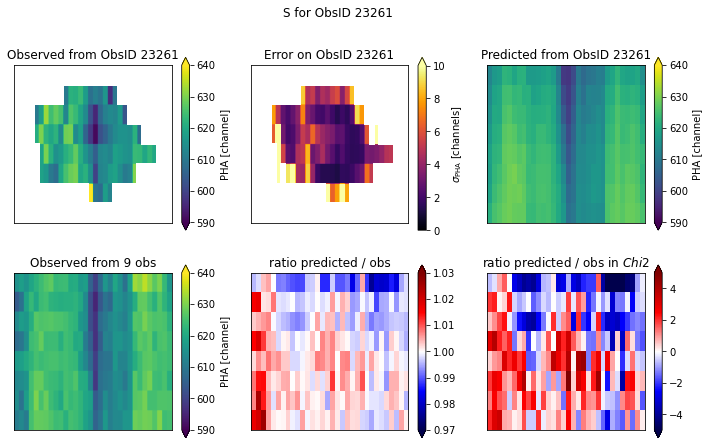

In [27]:
fig, axes = plot_one_comp_nine(loc1, 'S', loc['S'], locall, obsid, vmin=590, vmax=640)
out = fig.suptitle('S for ObsID 23261')

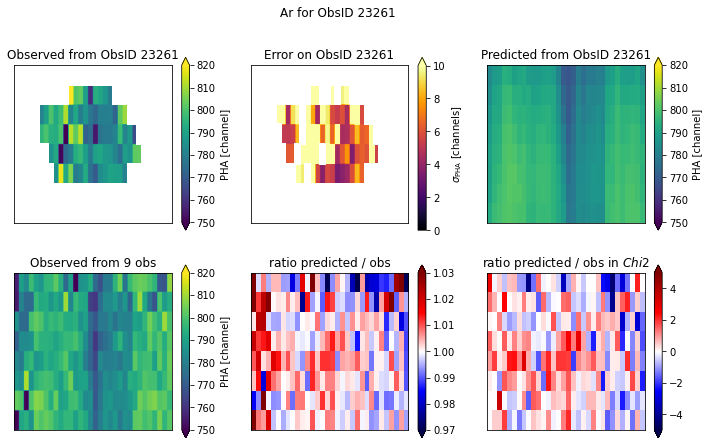

In [28]:
fig, axes = plot_one_comp_nine(loc1, 'Ar', loc['Ar'], locall, obsid, vmin=750, vmax=820)
out = fig.suptitle('Ar for ObsID 23261')

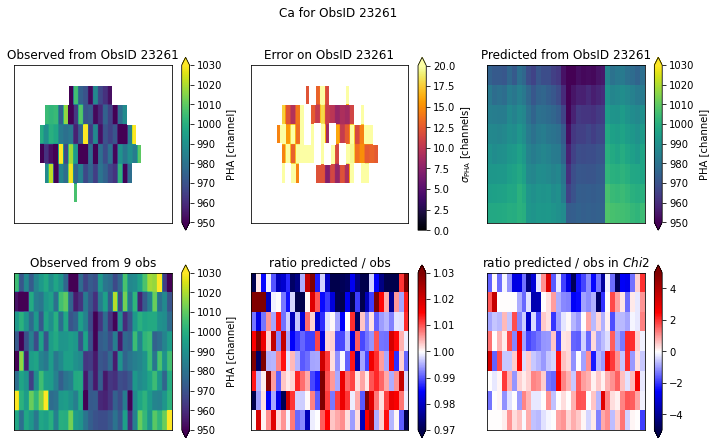

In [29]:
fig, axes = plot_one_comp_nine(loc1, 'Ca', loc['Ca'], locall, obsid, vmin=950, vmax=1030, vmaxerr=20)
out = fig.suptitle('Ca for ObsID 23261')

The singal of Cas A becomes weaker at higher energies and consequently the noise is much larger to Ar or Ca than for Si. There is still enough data for fit four components to it, but the comparison to the increasingly noisy data from the nine combined observations becomes less meaningfull. In particular in this case, one can see how the use of PCA as a noise reduction tool is useful. The gain map is clearly not as noisy as the bottom left panel in the figures. We know from the analsysis of the ECS data that much of the structure in the gain map can be seen at all energies and indeed we find that here in the predicted peak line position, too (top right panel in each figure). While details differ, the rightmost node always is the highest, the thord node is the lowest. The numbers increase from the top to the bottom as expected from CTI, and there is a droop in the middle of the chip towards the top. These patterns are not invented by the PCA, they can be seen in the combined data (bottom left panels in each figure) as well, but they are obscured by significant noise.

In [30]:
loc.write(f'CasA_from_{obsid}.lloc', format='ascii.fixed_width', 
          bookend=False, delimiter=None, overwrite=True)

The predicted maps for these four energies can now be passed to Nick, who can turn them into gain files for the CalDB using his interpolation scheme.

## How should observations be set up?

Going forward, we can be more deliberate in where exactly we place Cas A on the detector. As we saw above, this matters as regions not sample may not be fit well. For example, the node-to-node differences cannot be accurately predicted unless there is at least some data on each node. 

To quantify this a little better, I now present a series of plots similar to the ones above. For simplicity, I concentrate on Si here, where the signal in the combined data is best, which allows me to evaluate how accurate the predictions are. In the following, there is one row of plots for each ObsID or combination of ObsIDs. First, I look at each of the nine ObsIDs individually. We might also chose to combine two or more ObsIDs to achive a better spatial coverage of the detector, so I then show some possible combinations.

For each row, there are four plots, from left to right:
- Observed peak of Si line
- Predicted peak of Si line based on fitting the top four PCA components to the observed data
- Ratio between predicted position and data observed from all nine ObsIDs
- Cumulative histrogram of the ratios. The grey box marks the accuracy for 68% of the tiles ("$1\sigma$ of the tiles") to make it easy to read-off how this performes compared to the Chandra requirement.

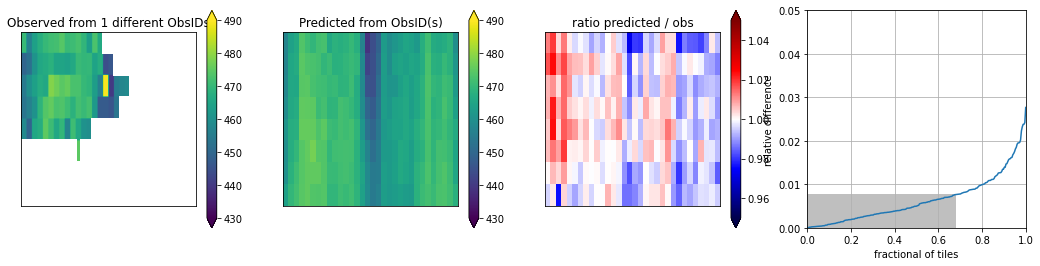

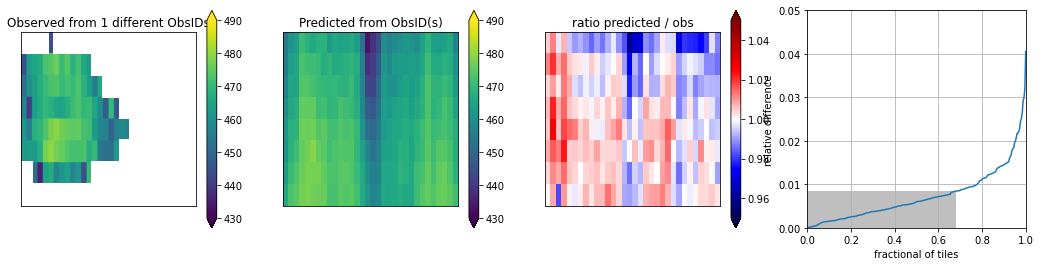

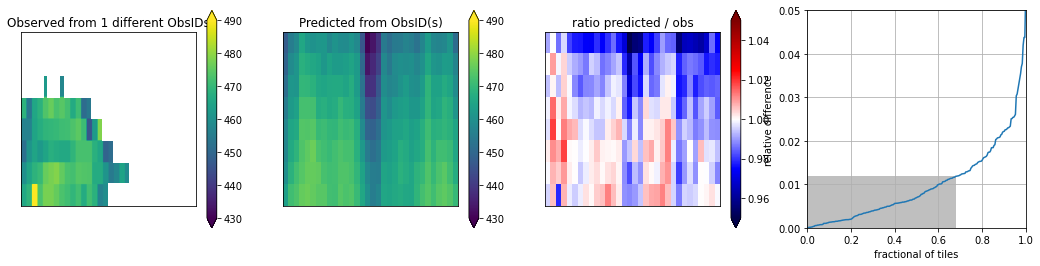

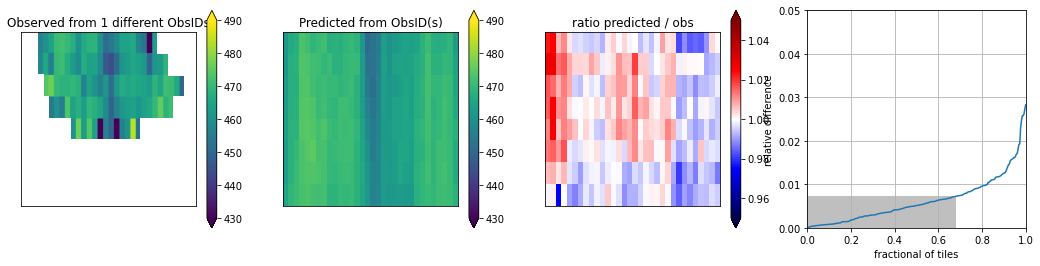

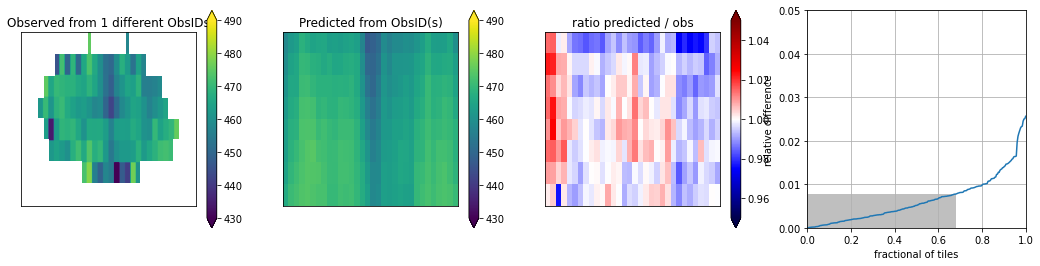

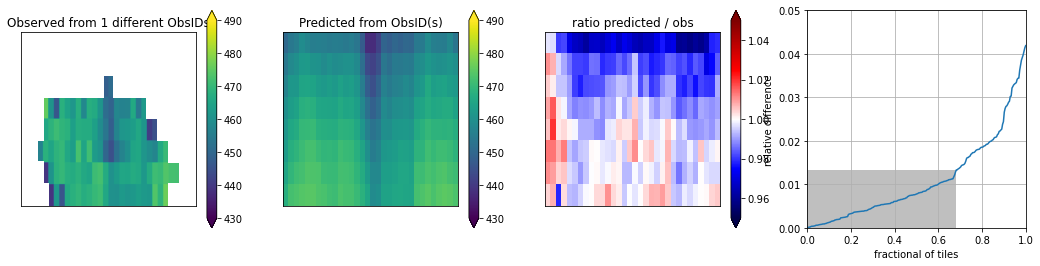

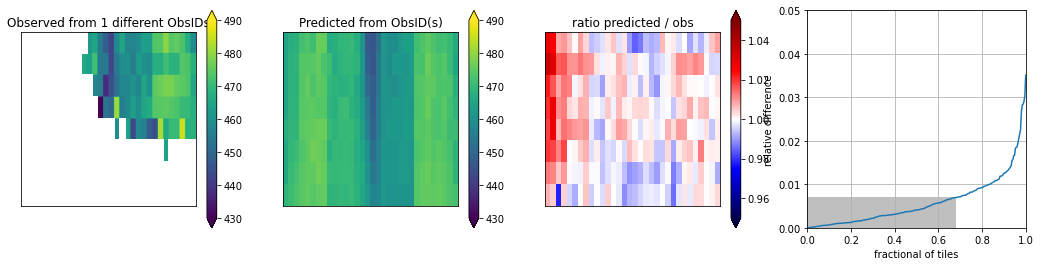

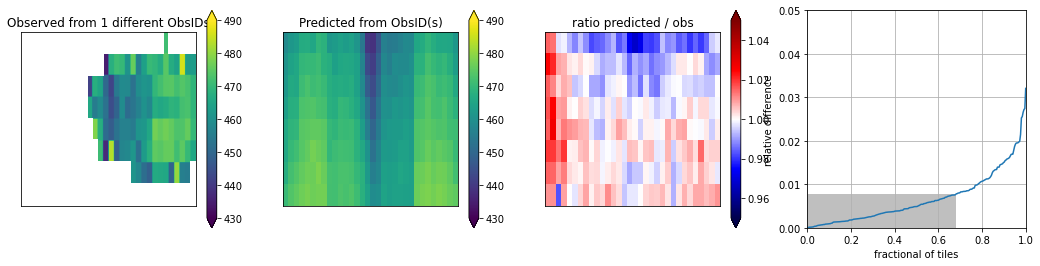

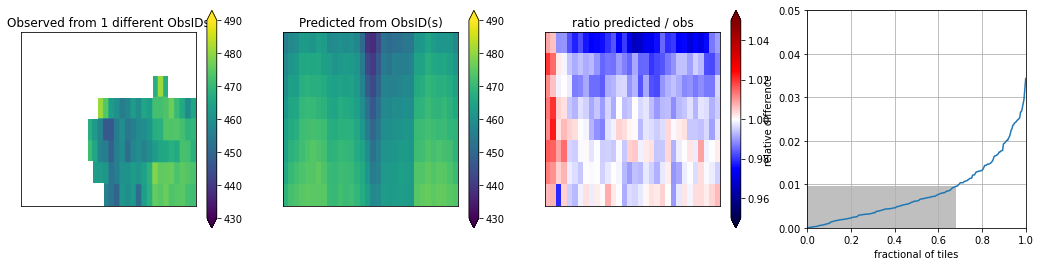

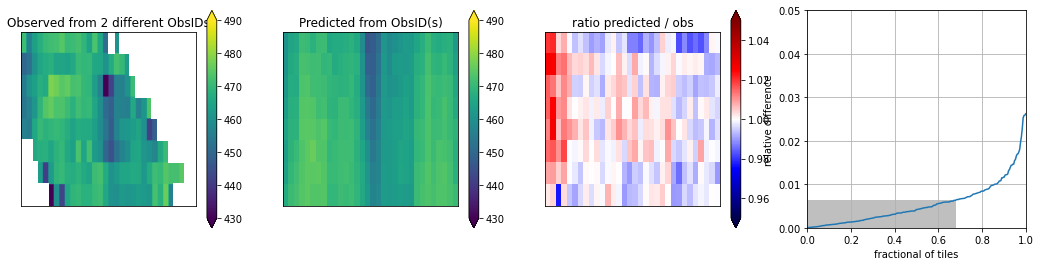

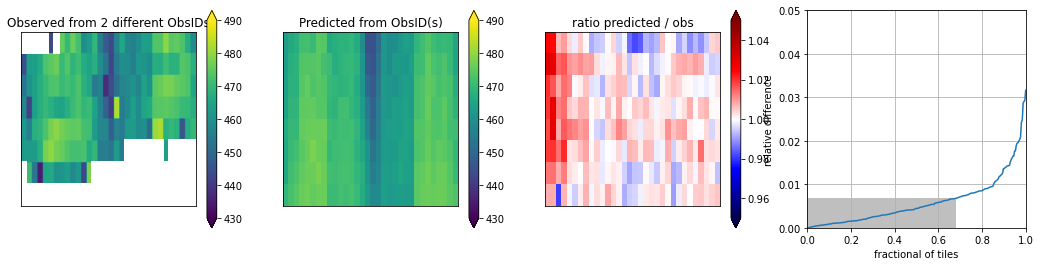

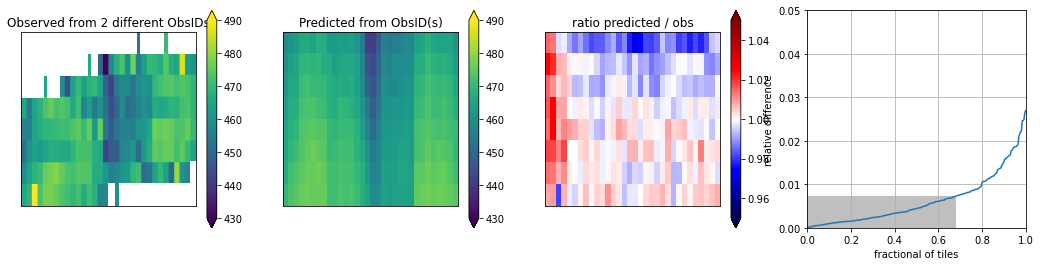

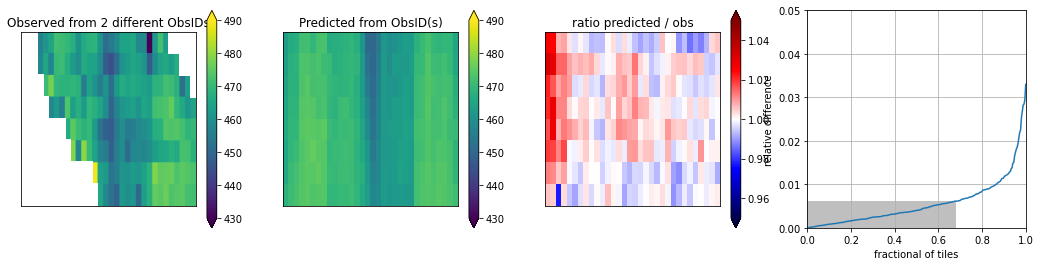

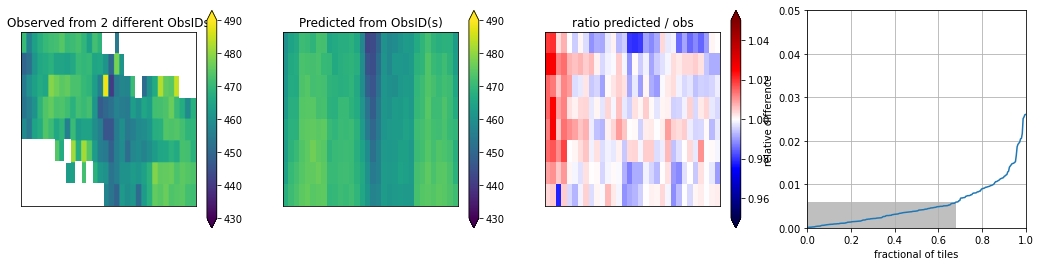

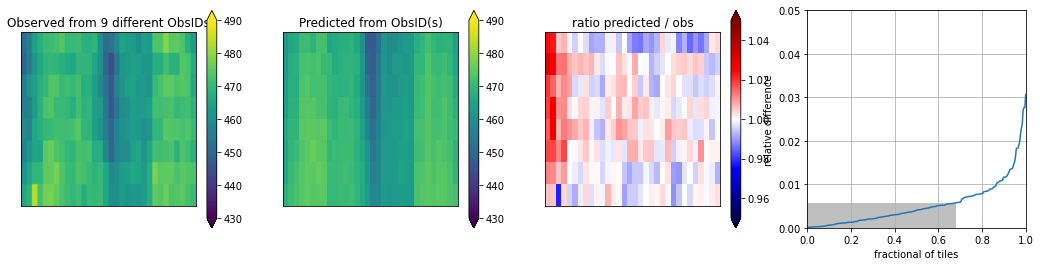

In [31]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

obsnumbers = [[23257], [23258], [23259], [23260], [23261], [23262], [23263], [23264], [23265],
                [23257, 23262], [23258, 23263], [23259, 23264], [23260, 23265], [23257, 23265],
                [23257, 23258, 23259, 23260, 23261, 23262, 23263, 23264, 23265]]
locfits = []
esterrs = []
fitres = table.Table(names=['rstat'], dtype=[float])

for obslist in obsnumbers:
    path = os.path.join('casa_pha_fits', 'o'.join([str(o) for o in obslist]))
    loc = table.Table.read(os.path.join(path, f'i3_noTG.lloc'), format='ascii')
    locdata = Data1D('locsi', x_array,                    
                 np.ma.masked_invalid(loc['Si']),
                 staterror=loc['Sierr'])
    for m in modelpca:
        m.fold(locdata)

    locfit = Fit(locdata, top4, stat=Chi2(), method=NelderMead())
    locfit.fit()
    fitres.add_row([locfit.calc_stat_info().rstat])
    locfits.append(locfit)
    esterrs.append(locfit.est_errors())
    fullccdpredicted = top4(x_array)
    siall = locall['Si']
    siall_err = locall['Sierr']
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4),
                            subplot_kw={'aspect':'equal'})

    im = axes[0].imshow(reg2im1024(loc, 'Si').T, origin='lower', vmin=430, vmax=490)
    out = plt.colorbar(im, ax=axes[0], extend='both')
    axes[0].set_title('Observed from {} different ObsIDs'.format(len(obslist)))
 
    im = axes[1].imshow(fullccdpredicted.reshape((32, 8)).T, 
                      extent=[0, 1023, 0, 1023], origin='lower', vmin=430, vmax=490)
    out = plt.colorbar(im, ax=axes[1], extend='both')
    axes[1].set_title(f'Predicted from ObsID(s)')
    im = axes[2].imshow((fullccdpredicted / siall).reshape((32, 8)).T, 
                      extent=[0, 1023, 0, 1023], 
                        origin='lower', vmin=0.95, vmax=1.05, cmap=plt.get_cmap('seismic'))
    out = plt.colorbar(im, ax=axes[2], extend='both')
    axes[2].set_title('ratio predicted / obs')
    
    for ax in axes[:3]:
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
    
    ratio = np.abs((fullccdpredicted / siall) -1)
    ratio.sort()
    axes[3].add_patch(mpatches.Rectangle([0, 0], 0.68, ratio[int(0.68 * len(ratio))], 
                                         ec="none", color='0.5', alpha=0.5))
    axes[3].plot(np.linspace(0, 1, len(ratio)), ratio)    
    axes[3].grid(True)
    axes[3].set_title('')
    axes[3].set_ylabel('relative difference')
    axes[3].set_xlabel('fractional of tiles')
    axes[3].set_aspect('auto')
    axes[3].set_xlim(0, 1)
    axes[3].set_ylim(0, 0.05)

**The most important result from this excercise is that we can reach an accuary of about 0.6% for 68% of the tiles. To do so, we need ot select a placement of Cas A roughly in the middle of the chip, such that all nodes are covered, or combine several observations, such that the combined observation covers all nodes.**

There are a few consistant patterns. In particular the ratio plots all show that the model overpredicts the left edge of the chip. This is true even when the prediction is made from the combined data of all observations. I have repeated these fits using a much larger number of PCA components and still observe this effect. A possible explantion is that the chip has evolved recently in a way not seen in the ECS data and that this spatial component is therefore not represented in the PCA components. However, ECS data taken both before and after (see the interactive figure in the ECS notebook) does not show the deep dip on the left side of the chip in the Al line, which is close in energy to the Si line shown here. In the ECS data, the gains drops off on the left chip edge, but consistent with the slight drop seen in the predictions (from about 470 in the middle of the first node to 460 on the edge of the chip), while the data shows a drop from 470 to 450. This feature drives the high end of the cumulative differences.

I do not have a consistent explanation at this point, but the kinematic pattern of the Si emitting gas in Cas A could manifest like this. In the middle of the chip, all nine observations contribute counts which come from different regions of Cas A. The some of that will average out the most extreme velocities. However, on the chip edges only one or two observations contribute. If these observations place a part of remnant with high line-of-sight velocity in this region, then the measured peak will be shifted. In other words, it is possible that the model is right, but the data is wrong.

In [32]:
for i, n in enumerate(esterrs[0].parnames):
    fitres[n] = [e.parvals[i] for e in esterrs]
    fitres[n + '_up'] = [e.parmaxes[i] for e in esterrs]
    fitres[n + '_down'] = [e.parmins[i] for e in esterrs]

In [33]:
for c in fitres.colnames:
    fitres[c].format = '{:.1f}'
fitres

rstat,comp0.ampl,comp0.ampl_up,comp0.ampl_down,comp1.ampl,comp1.ampl_up,comp1.ampl_down,comp2.ampl,comp2.ampl_up,comp2.ampl_down,comp3.ampl,comp3.ampl_up,comp3.ampl_down
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5.5,-7466.1,5.0,-5.0,38.6,5.5,-5.5,66.6,4.2,-4.2,-27.3,4.0,-4.0
5.2,-7470.2,3.9,-3.9,70.1,5.6,-5.6,56.5,4.8,-4.8,-31.2,3.8,-3.8
5.8,-7421.0,5.7,-5.7,89.8,5.8,-5.8,44.4,4.6,-4.6,-43.0,3.6,-3.6
3.5,-7475.8,6.0,-6.0,12.7,4.3,-4.3,43.9,3.1,-3.1,-22.7,4.0,-4.0
4.0,-7458.9,4.1,-4.1,37.7,4.5,-4.5,26.1,3.3,-3.3,-24.7,3.9,-3.9
5.1,-7408.1,4.9,-4.9,83.9,4.7,-4.7,-0.5,3.3,-3.3,-24.6,3.1,-3.1
3.6,-7488.3,4.5,-4.5,28.3,4.3,-4.3,56.8,3.4,-3.4,15.2,2.6,-2.6
4.6,-7471.7,2.8,-2.8,68.0,4.8,-4.8,37.8,3.8,-3.8,5.6,2.4,-2.4
5.6,-7432.1,4.8,-4.8,71.3,4.8,-4.8,22.3,4.4,-4.4,-0.2,2.3,-2.3


## Summary

Using just 2 ks of Cas A data, we can reach an accuary of about 0.6% in the gain for 68% of the tiles if Cas A is positioned correctly.

## Future work

Two points are still open:

- Correct the Cas A data for astrophysical motion. Archival data with independently determined gain (XMM, earlier Chandra where the gain is determined from the ECS, grating data) can be used for this purpose.
- Fit earlier data for comparison.

### Look earlier data
Cas A has been observed earlier in the mission when the ECS data was less noisy. We can use that earlier data from Cas A and compare it to the contemporaneous ECS data for verification of the method.

In [34]:
tab = table.Table.read('data/10642/repro/evt1_notgain_filts.fits', hdu='EVENTS')
tab = tab[tab['ccd_id'] == 3]

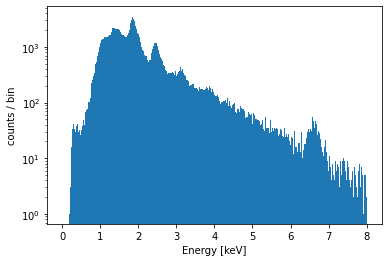

In [35]:
fig, ax = plt.subplots()
out = ax.hist(tab['energy'] / 1000, bins=1000, range=[0, 8])
ax.set_yscale('log')
ax.set_xlabel('Energy [keV]')
out = ax.set_ylabel('counts / bin')

In [36]:
tile = extract_tile(tab, loc[100])
hist, edges = np.histogram(tile['pha'], bins=np.arange(-0.5, np.max(tile['pha'])))
dtile = DataPHA('reg', np.arange(np.max(tile['pha'])), hist)

fit_res, fit_err = fit_allelem(dtile, fitstart, init_model, errors=True, stat=Cash(), method=NelderMead())

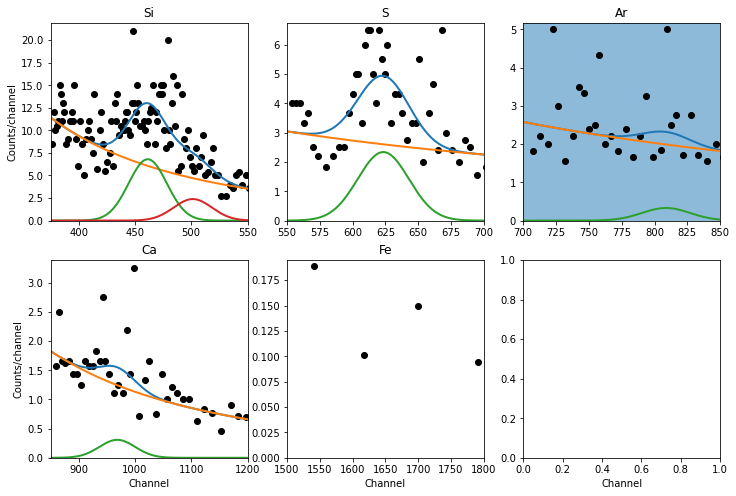

In [37]:
dtile.group_counts(10)
fig, axes = plot_allelem(dtile, fitstart, fit_res, fit_err=fit_err)

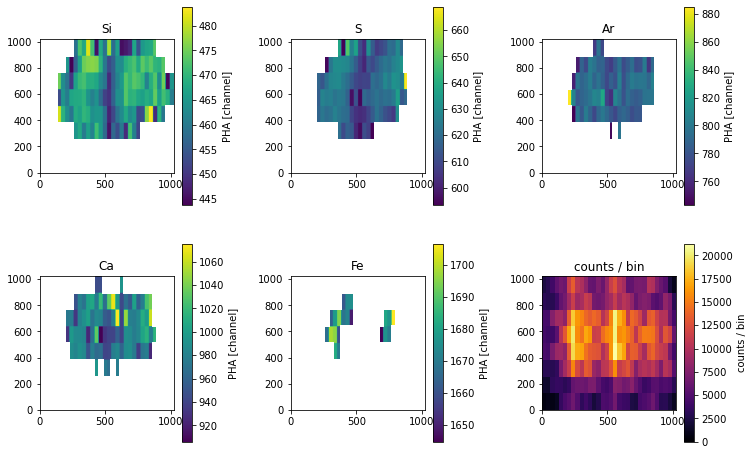

In [38]:
locall = table.Table.read(f'casa_pha_fits/10642/i3_noTG.lloc', format='ascii')
fig, axes = plot_loc_table(locall, evtall3, fitstart['element'])